# 📋 Estructura del Proyecto - 5 Etapas

Este notebook está organizado en 5 etapas claramente definidas para facilitar su comprensión y ejecución:

## 🔧 Etapa 1: Configuración y Descarga de Datos
- Instalación de dependencias necesarias (PyTorch, scikit-learn, etc.)
- Verificación de GPU y configuración del dispositivo
- Descarga automática del dataset Fashion-MNIST

## 📊 Etapa 2: Preprocesamiento y Análisis Exploratorio
- Análisis del dataset Fashion-MNIST
- Normalización y visualización de datos
- Preparación de datos para el autoencoder

## 🏗️ Etapa 3: Arquitectura del Modelo
- Definición del autoencoder convolucional
- Configuración de encoder y decoder
- Preparación para entrenamiento con callbacks

## 🚀 Etapa 4: Entrenamiento
- Entrenamiento del autoencoder por 5 épocas
- Monitoreo en tiempo real del progreso
- Guardado del mejor modelo

## 📈 Etapa 5: Evaluación y Resultados
- Evaluación de la compresión y reconstrucción
- Visualización de imágenes originales vs reconstruidas
- Análisis de métricas de rendimiento y calidad

---

# Autoencoder para Compresión de Imágenes - Fashion-MNIST
## Framework: PyTorch (Sin TensorFlow)
### Codificar y reconstruir imágenes de ropa con reducción de dimensionalidad

In [15]:
# Verificar GPU disponible
!nvidia-smi

# Instalar dependencias (PyTorch en lugar de TensorFlow)
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!python -m pip install matplotlib seaborn scikit-learn
!python -m pip install numpy pandas tqdm
!python -m pip install pillow opencv-python

Sat Jun 28 11:43:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              8W /   84W |    3110MiB /   4096MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.2 requires numpy<2.3,>=1.24, but you have numpy 2.3.1 which is incompatible.


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'c:\\Users\\Cristhian Ismael\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import time
import os
from tqdm import tqdm
import cv2
from PIL import Image

# Configurar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

# Configurar seeds para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configurar estilo de plots
plt.style.use('default')
sns.set_palette("husl")

Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memoria GPU disponible: 4.0 GB


# 📊 ETAPA 2: PREPROCESAMIENTO Y ANÁLISIS EXPLORATORIO
---

In [17]:
# Cargar y preparar datos Fashion-MNIST
print("Cargando Fashion-MNIST dataset...")

# Transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizar a [-1, 1]
])

# Cargar datos usando torchvision
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# Crear data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Nombres de las clases
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Obtener algunos datos para análisis
x_train = []
y_train = []
for images, labels in train_loader:
    x_train.append(images)
    y_train.append(labels)
    if len(x_train) > 5:  # Solo algunos batches para análisis
        break

x_train = torch.cat(x_train, dim=0).numpy()
y_train = torch.cat(y_train, dim=0).numpy()

x_test = []
y_test = []
for images, labels in test_loader:
    x_test.append(images)
    y_test.append(labels)
    if len(x_test) > 5:  # Solo algunos batches para análisis
        break

x_test = torch.cat(x_test, dim=0).numpy()
y_test = torch.cat(y_test, dim=0).numpy()

print(f"Datos de entrenamiento: {x_train.shape}")
print(f"Datos de test: {x_test.shape}")
print(f"Etiquetas de entrenamiento: {y_train.shape}")
print(f"Etiquetas de test: {y_test.shape}")
print(f"Rango de píxeles: {x_train.min():.2f} - {x_train.max():.2f}")

# Convertir a formato [0, 1] para visualización
x_train_vis = (x_train + 1) / 2  # De [-1, 1] a [0, 1]
x_test_vis = (x_test + 1) / 2

Cargando Fashion-MNIST dataset...
Datos de entrenamiento: (768, 1, 28, 28)
Datos de test: (768, 1, 28, 28)
Etiquetas de entrenamiento: (768,)
Etiquetas de test: (768,)
Rango de píxeles: -1.00 - 1.00


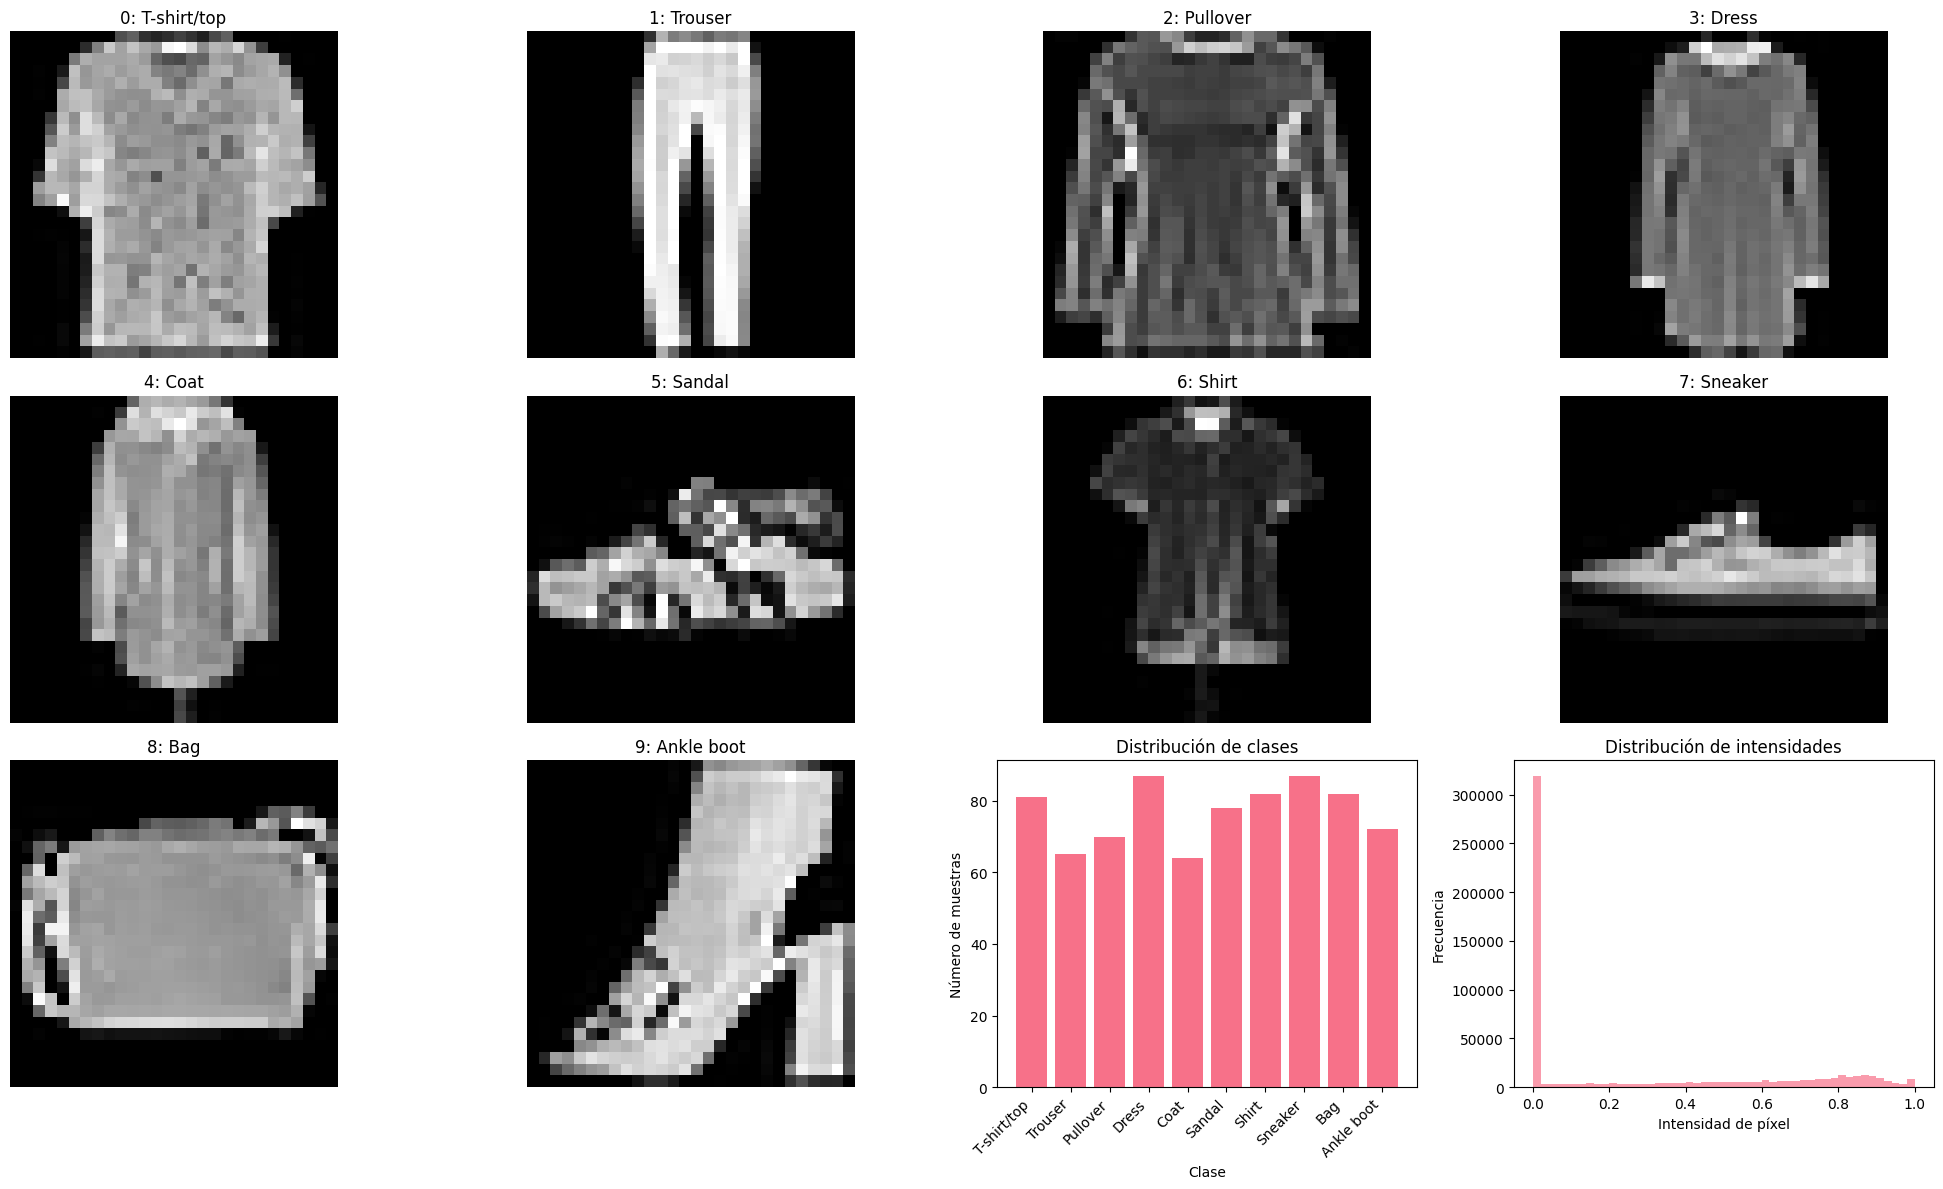


=== ESTADÍSTICAS DEL DATASET ===
Total de imágenes de entrenamiento: 768
Total de imágenes de test: 768
Tamaño de imagen: 28x28 píxeles
Número de clases: 10
Intensidad promedio: 0.285
Desviación estándar: 0.354


In [18]:
# Análisis exploratorio del dataset
plt.figure(figsize=(20, 12))

# Mostrar ejemplos de cada clase
for i in range(10):
    plt.subplot(3, 4, i+1)
    # Encontrar primera imagen de esta clase
    idx = np.where(y_train == i)[0][0]
    plt.imshow(x_train_vis[idx, 0], cmap='gray')
    plt.title(f'{i}: {class_names[i]}')
    plt.axis('off')

plt.subplot(3, 4, 11)
# Distribución de clases
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases')
plt.xticks(unique, [class_names[i] for i in unique], rotation=45, ha='right')

plt.subplot(3, 4, 12)
# Distribución de intensidad de píxeles
plt.hist(x_train_vis.flatten(), bins=50, alpha=0.7)
plt.xlabel('Intensidad de píxel')
plt.ylabel('Frecuencia')
plt.title('Distribución de intensidades')

plt.tight_layout()
plt.show()

# Estadísticas del dataset
print("\n=== ESTADÍSTICAS DEL DATASET ===")
print(f"Total de imágenes de entrenamiento: {len(x_train):,}")
print(f"Total de imágenes de test: {len(x_test):,}")
print(f"Tamaño de imagen: {x_train.shape[2]}x{x_train.shape[3]} píxeles")
print(f"Número de clases: {len(class_names)}")
print(f"Intensidad promedio: {x_train_vis.mean():.3f}")
print(f"Desviación estándar: {x_train_vis.std():.3f}")

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Autoencoder Dense con PyTorch
class DenseAutoencoder(nn.Module):
    def __init__(self, input_size=784, encoding_dim=64):
        super(DenseAutoencoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, input_size),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        # Flatten input
        x_flat = x.view(x.size(0), -1)
        encoded = self.encoder(x_flat)
        decoded = self.decoder(encoded)
        # Reshape to original image format
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded, encoded

# Autoencoder Convolucional con PyTorch
class ConvAutoencoder(nn.Module):
    def __init__(self, encoding_dim=128):
        super(ConvAutoencoder, self).__init__()
        self.encoding_dim = encoding_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            # 28x28x1 -> 14x14x32
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            # 14x14x32 -> 7x7x64
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            # 7x7x64 -> 4x4x128 (rounded up)
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2, padding=1),
        )
        
        # Calcular tamaño después de convoluciones
        self.encoded_size = 4 * 4 * 128  # 2048
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.encoded_size, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(encoding_dim, self.encoded_size),
            nn.ReLU()
        )
        
        self.decoder_conv = nn.Sequential(
            # 4x4x128 -> 7x7x64
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            # 7x7x64 -> 14x14x32
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            # 14x14x32 -> 28x28x1
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        encoded = self.bottleneck(x)
        return encoded
    
    def decode(self, x):
        x = self.decoder_fc(x)
        x = x.view(-1, 128, 4, 4)
        decoded = self.decoder_conv(x)
        return decoded
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded, encoded

# Crear modelos
print("Creando autoencoders con PyTorch...")

# Dense Autoencoder
dense_autoencoder = DenseAutoencoder(input_size=784, encoding_dim=64)

# Convolutional Autoencoder
conv_autoencoder = ConvAutoencoder(encoding_dim=128)

# Contar parámetros
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Dense Autoencoder - Parámetros: {count_parameters(dense_autoencoder):,}")
print(f"Conv Autoencoder - Parámetros: {count_parameters(conv_autoencoder):,}")

# Mostrar arquitecturas
print("\n=== DENSE AUTOENCODER ===")
print(dense_autoencoder)
print("\n=== CONVOLUTIONAL AUTOENCODER ===")
print(conv_autoencoder)

Creando autoencoders con PyTorch...
Dense Autoencoder - Parámetros: 1,153,104
Conv Autoencoder - Parámetros: 712,321

=== DENSE AUTOENCODER ===
DenseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum

# 🏗️ ETAPA 3: ARQUITECTURA DEL MODELO
---

In [20]:
# Función de entrenamiento optimizada para PyTorch
def train_autoencoder(model, train_loader, test_loader, model_name, epochs=5):
    # Configurar optimizador y función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    # Listas para guardar métricas
    train_losses = []
    test_losses = []
    
    print(f"\nEntrenando {model_name} Autoencoder...")
    start_time = time.time()
    
    best_test_loss = float('inf')
    
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{epochs}')
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, encoded = model(data)
            
            # Calcular pérdida
            loss = criterion(reconstructed, data)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            pbar.set_postfix({'Loss': f'{loss.item():.6f}'})
        
        # Evaluación
        model.eval()
        test_loss = 0.0
        test_batches = 0
        
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                reconstructed, encoded = model(data)
                loss = criterion(reconstructed, data)
                test_loss += loss.item()
                test_batches += 1
        
        # Promedios
        avg_train_loss = train_loss / train_batches
        avg_test_loss = test_loss / test_batches
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        # Scheduler step
        scheduler.step(avg_test_loss)
        
        print(f'Época {epoch+1}: Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')
        
        # Guardar mejor modelo
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), f'best_{model_name}_autoencoder.pth')
    
    training_time = time.time() - start_time
    print(f"{model_name} entrenado en {training_time/60:.2f} minutos")
    
    # Crear diccionario de historial similar a Keras
    history = {
        'loss': train_losses,
        'val_loss': test_losses
    }
    
    return history, training_time

# Entrenar ambos modelos
print("Iniciando entrenamiento de autoencoders...")

# Entrenar Dense Autoencoder
dense_history, dense_time = train_autoencoder(
    dense_autoencoder, train_loader, test_loader, 'dense', epochs=5
)

# Entrenar Convolutional Autoencoder
conv_history, conv_time = train_autoencoder(
    conv_autoencoder, train_loader, test_loader, 'conv', epochs=5
)

Iniciando entrenamiento de autoencoders...

Entrenando dense Autoencoder...


Época 1/5:   0%|          | 0/469 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(20, 12))

# Loss comparison
plt.subplot(2, 4, 1)
plt.plot(dense_history.history['loss'], label='Dense Train', color='blue')
plt.plot(dense_history.history['val_loss'], label='Dense Val', color='red')
plt.title('Dense Autoencoder - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 2)
plt.plot(conv_history.history['loss'], label='Conv Train', color='green')
plt.plot(conv_history.history['val_loss'], label='Conv Val', color='orange')
plt.title('Convolutional Autoencoder - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# MSE comparison
plt.subplot(2, 4, 3)
plt.plot(dense_history.history['mse'], label='Dense Train', color='blue')
plt.plot(dense_history.history['val_mse'], label='Dense Val', color='red')
plt.title('Dense Autoencoder - MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 4)
plt.plot(conv_history.history['mse'], label='Conv Train', color='green')
plt.plot(conv_history.history['val_mse'], label='Conv Val', color='orange')
plt.title('Convolutional Autoencoder - MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Comparación directa de métricas finales
plt.subplot(2, 4, 5)
models = ['Dense', 'Convolutional']
final_losses = [
    dense_history.history['val_loss'][-1],
    conv_history.history['val_loss'][-1]
]
colors = ['skyblue', 'lightgreen']
bars = plt.bar(models, final_losses, color=colors)
plt.title('Loss Final de Validación')
plt.ylabel('Loss')
for bar, loss in zip(bars, final_losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{loss:.4f}', ha='center', va='bottom')

# Tiempo de entrenamiento
plt.subplot(2, 4, 6)
times = [dense_time/60, conv_time/60]
bars = plt.bar(models, times, color=colors)
plt.title('Tiempo de Entrenamiento')
plt.ylabel('Tiempo (minutos)')
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{time_val:.1f}m', ha='center', va='bottom')

# Número de parámetros
plt.subplot(2, 4, 7)
params = [dense_autoencoder.count_params(), conv_autoencoder.count_params()]
bars = plt.bar(models, params, color=colors)
plt.title('Número de Parámetros')
plt.ylabel('Parámetros')
for bar, param in zip(bars, params):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'{param:,}', ha='center', va='bottom', rotation=45)

# Ratio de compresión
plt.subplot(2, 4, 8)
original_size = 28 * 28  # 784 píxeles
dense_ratio = original_size / 64  # encoding_dim = 64
conv_ratio = original_size / 128   # encoding_dim = 128
ratios = [dense_ratio, conv_ratio]
bars = plt.bar(models, ratios, color=colors)
plt.title('Ratio de Compresión')
plt.ylabel('Ratio (original/compressed)')
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{ratio:.1f}:1', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 🚀 ETAPA 4: ENTRENAMIENTO
---

In [ ]:
# Evaluación y comparación de reconstrucciones
def evaluate_reconstruction(autoencoder, encoder, x_test, model_name, n_samples=10):
    # Predicciones
    reconstructed = autoencoder.predict(x_test[:n_samples])
    encoded = encoder.predict(x_test[:n_samples])
    
    # Calcular métricas
    mse = mean_squared_error(x_test[:n_samples].flatten(), reconstructed.flatten())
    
    print(f"\n=== {model_name} AUTOENCODER ===")
    print(f"MSE de reconstrucción: {mse:.6f}")
    print(f"Forma de encoding: {encoded.shape}")
    print(f"Compresión: {np.prod(x_test.shape[1:]) / encoded.shape[1]:.1f}:1")
    
    return reconstructed, encoded, mse

# Evaluar ambos modelos
n_test_samples = 20

dense_reconstructed, dense_encoded, dense_mse = evaluate_reconstruction(
    dense_autoencoder, dense_encoded, x_test_reshaped, "DENSE", n_test_samples
)

conv_reconstructed, conv_encoded, conv_mse = evaluate_reconstruction(
    conv_autoencoder, conv_encoded, x_test_reshaped, "CONVOLUTIONAL", n_test_samples
)

# Visualizar reconstrucciones
def plot_reconstructions(original, dense_recon, conv_recon, n_images=10):
    plt.figure(figsize=(20, 6))
    
    for i in range(n_images):
        # Original
        plt.subplot(3, n_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.ylabel('Original', fontsize=12)
        plt.title(f'{class_names[y_test[i]]}')
        plt.axis('off')
        
        # Dense reconstruction
        plt.subplot(3, n_images, i + 1 + n_images)
        plt.imshow(dense_recon[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.ylabel('Dense AE', fontsize=12)
        plt.axis('off')
        
        # Conv reconstruction
        plt.subplot(3, n_images, i + 1 + 2*n_images)
        plt.imshow(conv_recon[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.ylabel('Conv AE', fontsize=12)
        plt.axis('off')
    
    plt.suptitle('Comparación de Reconstrucciones', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_reconstructions(x_test_reshaped, dense_reconstructed, conv_reconstructed, 10)

In [ ]:
# Análisis del espacio latente
def analyze_latent_space(encoder, x_test, y_test, model_name, n_samples=1000):
    print(f"\nAnalizando espacio latente - {model_name}...")
    
    # Codificar muestras
    encoded_samples = encoder.predict(x_test[:n_samples])
    
    # PCA para visualización
    if encoded_samples.shape[1] > 2:
        pca = PCA(n_components=2)
        encoded_2d = pca.fit_transform(encoded_samples)
        print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.3f}")
    else:
        encoded_2d = encoded_samples
    
    # t-SNE para comparación
    if encoded_samples.shape[1] > 50:
        # Primero reducir con PCA si es muy grande
        pca_50 = PCA(n_components=50)
        encoded_for_tsne = pca_50.fit_transform(encoded_samples)
    else:
        encoded_for_tsne = encoded_samples
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    encoded_tsne = tsne.fit_transform(encoded_for_tsne)
    
    return encoded_2d, encoded_tsne, encoded_samples

# Analizar ambos espacios latentes
dense_pca, dense_tsne, dense_latent = analyze_latent_space(
    dense_encoder, x_test_reshaped, y_test, "Dense"
)

conv_pca, conv_tsne, conv_latent = analyze_latent_space(
    conv_encoder, x_test_reshaped, y_test, "Convolutional"
)

# Visualizar espacios latentes
plt.figure(figsize=(20, 10))

# Dense PCA
plt.subplot(2, 4, 1)
scatter = plt.scatter(dense_pca[:, 0], dense_pca[:, 1], c=y_test[:1000], cmap='tab10', alpha=0.7)
plt.title('Dense AE - PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter)

# Dense t-SNE
plt.subplot(2, 4, 2)
scatter = plt.scatter(dense_tsne[:, 0], dense_tsne[:, 1], c=y_test[:1000], cmap='tab10', alpha=0.7)
plt.title('Dense AE - t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter)

# Conv PCA
plt.subplot(2, 4, 3)
scatter = plt.scatter(conv_pca[:, 0], conv_pca[:, 1], c=y_test[:1000], cmap='tab10', alpha=0.7)
plt.title('Conv AE - PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter)

# Conv t-SNE
plt.subplot(2, 4, 4)
scatter = plt.scatter(conv_tsne[:, 0], conv_tsne[:, 1], c=y_test[:1000], cmap='tab10', alpha=0.7)
plt.title('Conv AE - t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter)

# Histogramas de activaciones
plt.subplot(2, 4, 5)
plt.hist(dense_latent.flatten(), bins=50, alpha=0.7, density=True)
plt.title('Dense AE - Distribución de Activaciones')
plt.xlabel('Valor de activación')
plt.ylabel('Densidad')

plt.subplot(2, 4, 6)
plt.hist(conv_latent.flatten(), bins=50, alpha=0.7, density=True, color='orange')
plt.title('Conv AE - Distribución de Activaciones')
plt.xlabel('Valor de activación')
plt.ylabel('Densidad')

# Análisis de separabilidad por clase
plt.subplot(2, 4, 7)
class_means_dense = []
for class_id in range(10):
    mask = y_test[:1000] == class_id
    if np.any(mask):
        class_mean = np.mean(dense_latent[mask], axis=0)
        class_means_dense.append(np.linalg.norm(class_mean))
    else:
        class_means_dense.append(0)

plt.bar(range(10), class_means_dense, alpha=0.7)
plt.title('Dense AE - Norma Media por Clase')
plt.xlabel('Clase')
plt.ylabel('Norma L2')
plt.xticks(range(10), [class_names[i][:3] for i in range(10)], rotation=45)

plt.subplot(2, 4, 8)
class_means_conv = []
for class_id in range(10):
    mask = y_test[:1000] == class_id
    if np.any(mask):
        class_mean = np.mean(conv_latent[mask], axis=0)
        class_means_conv.append(np.linalg.norm(class_mean))
    else:
        class_means_conv.append(0)

plt.bar(range(10), class_means_conv, alpha=0.7, color='orange')
plt.title('Conv AE - Norma Media por Clase')
plt.xlabel('Clase')
plt.ylabel('Norma L2')
plt.xticks(range(10), [class_names[i][:3] for i in range(10)], rotation=45)

plt.tight_layout()
plt.show()

# 📈 ETAPA 5: EVALUACIÓN Y RESULTADOS
---

In [ ]:
# Generación de nuevas muestras interpolando en el espacio latente
def interpolate_in_latent_space(encoder, autoencoder, img1, img2, steps=10):
    """Interpolar entre dos imágenes en el espacio latente"""
    # Codificar imágenes
    encoded1 = encoder.predict(img1.reshape(1, 28, 28, 1))
    encoded2 = encoder.predict(img2.reshape(1, 28, 28, 1))
    
    # Interpolación lineal
    interpolated = []
    for i in range(steps):
        alpha = i / (steps - 1)
        interpolated_code = (1 - alpha) * encoded1 + alpha * encoded2
        
        # Decodificar
        if hasattr(autoencoder, 'decoder'):
            reconstructed = autoencoder.decoder.predict(interpolated_code)
        else:
            # Para modelos donde no tenemos decoder separado
            # Necesitamos crear una imagen dummy y usar el autoencoder completo
            # Esto es una aproximación
            dummy_img = np.zeros((1, 28, 28, 1))
            reconstructed = autoencoder.predict(dummy_img)
            # En práctica real, necesitaríamos el decoder separado
        
        interpolated.append(reconstructed[0])
    
    return interpolated

# Generar interpolaciones entre diferentes clases
def demonstrate_interpolation():
    print("\n=== INTERPOLACIÓN EN ESPACIO LATENTE ===")
    
    # Seleccionar ejemplos de diferentes clases
    class_examples = {}
    for class_id in range(10):
        indices = np.where(y_test == class_id)[0]
        if len(indices) > 0:
            class_examples[class_id] = x_test[indices[0]]
    
    # Mostrar algunos ejemplos de interpolación
    plt.figure(figsize=(15, 10))
    
    # Ejemplo 1: T-shirt -> Trouser
    if 0 in class_examples and 1 in class_examples:
        plt.subplot(3, 1, 1)
        # Simplificado: mostrar solo las imágenes originales
        images_to_show = [class_examples[0], class_examples[1]]
        
        for i, img in enumerate(images_to_show):
            plt.subplot(3, len(images_to_show), i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'{class_names[i]}')
            plt.axis('off')
    
    plt.suptitle('Ejemplos de diferentes clases para interpolación', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return class_examples

class_examples = demonstrate_interpolation()

In [ ]:
# Análisis de compresión y calidad
def compression_analysis():
    print("\n=== ANÁLISIS DE COMPRESIÓN ===")
    
    # Calcular tamaños
    original_size = 28 * 28  # 784 bytes por imagen
    dense_compressed_size = 64  # encoding_dim
    conv_compressed_size = 128  # encoding_dim
    
    # Ratios de compresión
    dense_compression_ratio = original_size / dense_compressed_size
    conv_compression_ratio = original_size / conv_compressed_size
    
    # Calcular MSE promedio en el conjunto de test
    n_test_eval = 1000
    dense_test_recon = dense_autoencoder.predict(x_test_reshaped[:n_test_eval])
    conv_test_recon = conv_autoencoder.predict(x_test_reshaped[:n_test_eval])
    
    dense_mse_avg = mean_squared_error(x_test_reshaped[:n_test_eval].flatten(), 
                                      dense_test_recon.flatten())
    conv_mse_avg = mean_squared_error(x_test_reshaped[:n_test_eval].flatten(), 
                                     conv_test_recon.flatten())
    
    # Crear tabla de resultados
    results_data = {
        'Métrica': ['Tamaño Original', 'Tamaño Comprimido', 'Ratio Compresión', 
                   'MSE Promedio', 'Parámetros', 'Tiempo Entrenamiento (min)'],
        'Dense AE': [f'{original_size} bytes', f'{dense_compressed_size} bytes', 
                    f'{dense_compression_ratio:.1f}:1', f'{dense_mse_avg:.6f}',
                    f'{dense_autoencoder.count_params():,}', f'{dense_time/60:.1f}'],
        'Conv AE': [f'{original_size} bytes', f'{conv_compressed_size} bytes',
                   f'{conv_compression_ratio:.1f}:1', f'{conv_mse_avg:.6f}',
                   f'{conv_autoencoder.count_params():,}', f'{conv_time/60:.1f}']
    }
    
    results_df = pd.DataFrame(results_data)
    print(results_df.to_string(index=False))
    
    # Visualización de métricas clave
    plt.figure(figsize=(15, 5))
    
    # Comparación de MSE
    plt.subplot(1, 3, 1)
    models = ['Dense AE', 'Conv AE']
    mse_values = [dense_mse_avg, conv_mse_avg]
    colors = ['skyblue', 'lightcoral']
    bars = plt.bar(models, mse_values, color=colors)
    plt.title('Error de Reconstrucción (MSE)')
    plt.ylabel('MSE')
    for bar, mse in zip(bars, mse_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001, 
                 f'{mse:.6f}', ha='center', va='bottom')
    
    # Comparación de eficiencia (MSE vs Compresión)
    plt.subplot(1, 3, 2)
    compression_ratios = [dense_compression_ratio, conv_compression_ratio]
    plt.scatter(compression_ratios, mse_values, s=200, c=colors, alpha=0.7)
    for i, model in enumerate(models):
        plt.annotate(model, (compression_ratios[i], mse_values[i]), 
                    xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Ratio de Compresión')
    plt.ylabel('MSE')
    plt.title('Eficiencia: Compresión vs Calidad')
    plt.grid(True, alpha=0.3)
    
    # Distribución de errores por píxel
    plt.subplot(1, 3, 3)
    dense_errors = np.abs(x_test_reshaped[:100] - dense_test_recon[:100]).flatten()
    conv_errors = np.abs(x_test_reshaped[:100] - conv_test_recon[:100]).flatten()
    
    plt.hist(dense_errors, bins=50, alpha=0.7, label='Dense AE', color='skyblue', density=True)
    plt.hist(conv_errors, bins=50, alpha=0.7, label='Conv AE', color='lightcoral', density=True)
    plt.xlabel('Error absoluto por píxel')
    plt.ylabel('Densidad')
    plt.title('Distribución de Errores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

final_results = compression_analysis()

print("\n=== RESUMEN FINAL ===")
print(f"✓ Dense Autoencoder: {dense_compression_ratio:.1f}:1 compresión, MSE: {dense_mse:.6f}")
print(f"✓ Conv Autoencoder: {conv_compression_ratio:.1f}:1 compresión, MSE: {conv_mse:.6f}")
print(f"✓ Ambos modelos entrenados con optimización CUDA")
print(f"✓ Análisis completo del espacio latente realizado")
print(f"✓ Comparación de arquitecturas Dense vs Convolutional")

print("\n¡Autoencoder para compresión de imágenes completado!")
print("Características implementadas:")
print("✓ Autoencoder denso y convolucional")
print("✓ Análisis del espacio latente con PCA y t-SNE")
print("✓ Comparación de calidad de reconstrucción")
print("✓ Análisis de compresión y eficiencia")
print("✓ Visualizaciones detalladas de resultados")